# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

# Conclusions
1.In the clean Data Frame, dropping outliers, there are only 15 countries where the humidity is higher than 100%. 

2.Central Tendency measures for those countries, shows a max temperature of 99F, min temperature of 23F, an average humidity of 69.99%, cloudiness of 46.58% and wind speed of 7.78 mph

3.The latitued and longitude plotting only shows one positive correlation as for Max Temperature vs Latitud from both, Northern and Southern Hemispheres, exposed by a linear regression of -0.8 and 0.7 respectively. For the rest of the correlation analyses, correspondint to humidity, cloudiness and wind speed, for both Hemispheres is negative, so there is no correlation at all. 

In [1]:
#Dependencies and Setup
#Importing base libraries
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from scipy.stats import linregress
from pprint import pprint
from datetime import datetime

# Importing libraries needed for API requests
import json
import requests

#importing random library for randomizing longitudes
import random

# Importing library to get the nearest city for given (latitude, longitude).
#***First install *pip install citipy on bash*
from citipy import citipy

# Import API key from a file that is ignored by Git (.gitignore file) so the key isn't exposed to the public
from api_keys import weather_api_key
from api_keys import g_key

# Output File (CSV)
cities= "output_data/cities.csv"
cities_df = pd.read_csv(cities)
cities_df

,City_ID,City,Cloudiness,Country,Date,Humidity,Lat,Lng,Max Temp,Wind Speed
0,0,ostrovnoy,2,RU,1558378754,72,68.05,39.51,37.50,7.16
1,1,mahebourg,75,MU,1558378503,74,-20.41,57.70,78.80,11.41
2,2,qaanaaq,25,GL,1558378755,73,77.48,-69.36,22.20,2.37
3,3,zhuhai,0,CN,1558378755,39,40.71,112.04,44.60,4.47
4,4,cape town,20,ZA,1558378755,76,-33.93,18.42,55.99,8.05
...,...,...,...,...,...,...,...,...,...,...
543,543,yabrud,0,SY,1558378840,32,33.97,36.66,80.60,8.05
544,544,paraiso,5,MX,1558378898,4,24.01,-104.61,84.20,16.11
545,545,veraval,0,FR,1558378898,62,49.65,0.71,61.00,8.05
546,546,novyy urgal,100,RU,1558378899,93,51.07,132.56,49.74,2.68


In [2]:
cities_df = pd.read_csv(cities).count()
print(cities_df)

City_ID       548
City          548
Cloudiness    548
Country       544
Date          548
Humidity      548
Lat           548
Lng           548
Max Temp      548
Wind Speed    548
dtype: int64


## Generate Cities List

In [34]:
# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

# List for holding lat_lngs and cities
lat_lngs = []
cities = []
countries = []

# Create a set of random lat and long combinations and zip into a list of tuples
lats = np.random.uniform(low=-90.000, high=90.000, size=1500)
lngs = np.random.uniform(low=-180.000, high=180.000, size=1500)

#Zip latitude and longitude
lat_lngs_zip = zip(lats, lngs)


# Identify nearest city for each lat, lng combination using the Citypy package to return a unique city and country code
for lat_lng in lat_lngs_zip:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    country = citipy.nearest_city(lat_lng[0], lat_lng[1]).country_code
    
    # If the city is unique and not appear, then add it to a list
    if city not in cities:
        cities.append(city)
        countries.append(country)

# Combine the two lists into a list of tuples using the zip function
city_country = zip(cities,countries)   

# Print the city count to confirm sufficient count ( Greater than 500 )
len(cities)

607

In [35]:
#Building query url
url = "http://api.openweathermap.org/data/2.5/weather?"
units = "imperial"
query_url = f"{url}appid={weather_api_key}&units={units}&q="
query_url

#API Calls
#Get Weather Data 

weather_response = requests.get(query_url + city)
weather_json = weather_response.json()
print(json.dumps(weather_json, indent=4))

{
    "coord": {
        "lon": -97.86,
        "lat": 55.74
    },
    "weather": [
        {
            "id": 801,
            "main": "Clouds",
            "description": "few clouds",
            "icon": "02n"
        }
    ],
    "base": "stations",
    "main": {
        "temp": 41,
        "feels_like": 35.6,
        "temp_min": 41,
        "temp_max": 41,
        "pressure": 1014,
        "humidity": 86
    },
    "visibility": 10000,
    "wind": {
        "speed": 4.7,
        "deg": 270
    },
    "clouds": {
        "all": 20
    },
    "dt": 1599279237,
    "sys": {
        "type": 1,
        "id": 935,
        "country": "CA",
        "sunrise": 1599219805,
        "sunset": 1599268653
    },
    "timezone": -18000,
    "id": 6165406,
    "name": "Thompson",
    "cod": 200
}


In [36]:
#Proving status request as [200] means as universally accepted code for a successful HTTP reques ok, as protocol
#https://idratherbewriting.com/learnapidoc/docapis_doc_status_codes.html
print(requests.get(query_url + city))


<Response [200]>


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [37]:
# Set Up lists to hold reponse data
cityName = []
latitude = []
longitude = []
maxTemperature = []
humidity = []
cloudiness = []
windSpeed = []
country = []
date = []


# Processing Record Counter Starting a 1
processRecording = 1

# Print Starting Log Statement
print(f"Beginning Data Retrieval")
print(f"-------------------------------")

# Loop Through List of Cities & Perform a Request for Data on Each
for city in cities:

# Exception Handling
    try:
        response = requests.get(query_url + city).json()
        cityName.append(response["name"])
        latitude.append(response["coord"]["lat"])
        longitude.append(response["coord"]["lon"])
        maxTemperature.append(response["main"]["temp_max"])
        humidity.append(response["main"]["humidity"])
        cloudiness.append(response["clouds"]["all"])
        windSpeed.append(response["wind"]["speed"])
        country.append(response["sys"]["country"])
        date.append(response["dt"])
        cityRecord = response["name"]
        print(f"Process Recording {processRecording} | {cityRecord}") 
        
        
        # Increase Processing Record Counter by 1 For Each Loop
        processRecording += 1
        
    except:
        #Format as requested on example
        print("City not found. Skipping...") 
    continue

# Print Ending Log Statement
print(f"-------------------------------")
print(f"Data Retrieval Complete")
print(f"-------------------------------")

Beginning Data Retrieval
-------------------------------
Process Recording 1 | Cabo San Lucas
City not found. Skipping...
Process Recording 2 | Rivadavia
Process Recording 3 | Saint-Philippe
Process Recording 4 | Hilo
Process Recording 5 | Pevek
Process Recording 6 | Tiznit Province
Process Recording 7 | Mataura
Process Recording 8 | Torbay
Process Recording 9 | Ribeira Grande
City not found. Skipping...
Process Recording 10 | Vestmannaeyjar
Process Recording 11 | São João da Barra
Process Recording 12 | Dali
Process Recording 13 | Kudahuvadhoo
Process Recording 14 | Nelson
Process Recording 15 | Rikitea
Process Recording 16 | Dikson
City not found. Skipping...
Process Recording 17 | Bethel
Process Recording 18 | Prince Rupert
Process Recording 19 | Khilok
Process Recording 20 | Half Moon Bay
Process Recording 21 | Tuatapere
City not found. Skipping...
Process Recording 22 | San Cristobal
Process Recording 23 | Jamestown
Process Recording 24 | Ponta do Sol
Process Recording 25 | Ţahţā


Process Recording 227 | São Miguel do Araguaia
Process Recording 228 | Lagoa
Process Recording 229 | Deputatsky
Process Recording 230 | Rio Grande
Process Recording 231 | Bauchi
Process Recording 232 | Ixtapa
Process Recording 233 | Ranong
Process Recording 234 | Toktogul
Process Recording 235 | Santo Antônio do Içá
Process Recording 236 | Lodja
Process Recording 237 | Waingapu
Process Recording 238 | Makkah al Mukarramah
Process Recording 239 | Pangnirtung
Process Recording 240 | Vestmanna
Process Recording 241 | Katsuura
Process Recording 242 | Cabras
Process Recording 243 | Lompoc
Process Recording 244 | Hammerfest
Process Recording 245 | Te Anau
City not found. Skipping...
Process Recording 246 | College
Process Recording 247 | Boyuibe
City not found. Skipping...
Process Recording 248 | Nikolskoye
Process Recording 249 | Jefferson City
Process Recording 250 | Mogadishu
Process Recording 251 | Oistins
Process Recording 252 | Suez
Process Recording 253 | Carballo
Process Recording 25

Process Recording 455 | Goianésia
Process Recording 456 | Amapá
Process Recording 457 | Sisimiut
Process Recording 458 | Quatre Cocos
Process Recording 459 | Cherskiy
Process Recording 460 | Turukhansk
Process Recording 461 | Minas
Process Recording 462 | Zhangaözen
Process Recording 463 | Lesosibirsk
City not found. Skipping...
Process Recording 464 | Monzón
Process Recording 465 | Haines Junction
Process Recording 466 | Monterey
Process Recording 467 | Dixon
Process Recording 468 | Rocha
Process Recording 469 | Antalaha
Process Recording 470 | Kisangani
Process Recording 471 | Biak
Process Recording 472 | Evensk
Process Recording 473 | Maxixe
Process Recording 474 | Tual
Process Recording 475 | Hennenman
Process Recording 476 | Shimoda
Process Recording 477 | Manggar
Process Recording 478 | Abu Samrah
Process Recording 479 | La Ronge
Process Recording 480 | Odesskoye
Process Recording 481 | Zapotiltic
City not found. Skipping...
Process Recording 482 | Khanbari
Process Recording 483 

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [38]:
# Create DataFrame for columns Cities, Latitude, Longitude, Temperature, Humidity, Cloudiness and Wind Speed
weatherDictionary = {
    "City": cityName,
    "Lat": latitude,
    "Lng": longitude,
    "Max Temp": maxTemperature,
    "Humidity": humidity,
    "Cloudiness": cloudiness,
    "Wind Speed": windSpeed,
    "Country": country,
    "Date": date,
}

weather_df = pd.DataFrame(weatherDictionary)
weather_df.count()

City          553
Lat           553
Lng           553
Max Temp      553
Humidity      553
Cloudiness    553
Wind Speed    553
Country       553
Date          553
dtype: int64

In [39]:
# Display DataFrame
weather_df

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,Cabo San Lucas,22.89,-109.91,84.99,78,5,8.05,MX,1599279129
1,Rivadavia,-33.19,-68.46,51.80,40,0,8.05,AR,1599279495
2,Saint-Philippe,-21.36,55.77,64.40,88,75,9.17,RE,1599279000
3,Hilo,19.73,-155.09,82.40,58,90,9.17,US,1599279496
4,Pevek,69.70,170.31,36.16,83,95,1.77,RU,1599278979
...,...,...,...,...,...,...,...,...,...
548,Departamento de Maldonado,-34.67,-54.92,48.00,100,70,4.70,UY,1599279386
549,Provincia di Imperia,43.97,7.78,71.60,60,0,1.12,IT,1599279677
550,Touros,-5.20,-35.46,71.60,94,75,6.93,BR,1599279395
551,Villavieja,39.85,-0.18,66.99,79,0,3.18,ES,1599279678


In [40]:
##Measures of Central Tendecy for all cities from DataFrame
weather_df.describe()

,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Date
count,553.000000,553.000000,553.000000,553.000000,553.000000,553.000000,5.530000e+02
mean,21.288915,16.220886,66.971844,70.806510,46.869801,7.761863,1.599279e+09
std,33.042227,88.171942,14.107253,20.463926,38.001302,5.249388,1.822980e+02
min,-54.800000,-179.170000,23.580000,11.000000,0.000000,0.400000,1.599279e+09
25%,-4.390000,-59.800000,55.110000,61.000000,4.000000,3.420000,1.599279e+09
50%,26.590000,23.680000,69.620000,76.000000,43.000000,6.930000,1.599280e+09
75%,49.150000,88.400000,78.350000,86.000000,82.000000,10.780000,1.599280e+09
max,78.220000,179.320000,99.000000,100.000000,100.000000,30.890000,1.599280e+09


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [41]:
humidity_df= weather_df.loc[weather_df["Humidity"] >=100]
humidity_df 

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
7,Torbay,47.67,-52.73,66.99,100,75,13.87,CA,1599279497
123,Sjøvegan,68.87,17.85,51.80,100,100,13.87,NO,1599279534
148,Kayes,14.00,-11.00,77.00,100,40,5.61,ML,1599279507
157,Edéa,3.80,10.13,75.20,100,75,2.24,CM,1599279546
221,Laas,46.62,10.70,54.00,100,1,2.64,IT,1599279188
269,South River,40.45,-74.39,64.00,100,68,5.46,US,1599279582
299,Longyearbyen,78.22,15.64,42.80,100,75,9.17,SJ,1599279132
302,Gunjur,13.20,-16.73,77.00,100,75,5.82,GM,1599279370
344,Rovaniemi,66.50,25.72,53.60,100,40,10.29,FI,1599279494
348,Barcelos,41.54,-8.62,66.00,100,90,4.70,PT,1599278966


In [42]:
#  Get the indices of cities that have humidity over 100%.
humidity_df.index

Int64Index([7, 123, 148, 157, 221, 269, 299, 302, 344, 348, 369, 411, 460, 484,
            548],
           dtype='int64')

In [43]:
#Measures of Central Tendecy for cities that have humidity over 100%
humidity_df.describe()

,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Date
count,15.000000,15.000000,15.000000,15.0,15.000000,15.000000,1.500000e+01
mean,35.884667,-10.514000,57.572667,100.0,57.133333,7.074000,1.599279e+09
std,36.178512,34.209235,13.905500,0.0,28.575381,4.761383,1.936578e+02
min,-34.670000,-74.390000,26.600000,100.0,1.000000,1.120000,1.599279e+09
25%,13.600000,-35.035000,49.900000,100.0,35.000000,4.700000,1.599279e+09
50%,46.620000,-8.620000,54.000000,100.0,70.000000,5.460000,1.599279e+09
75%,66.270000,16.745000,66.495000,100.0,75.000000,9.730000,1.599280e+09
max,78.220000,30.220000,77.000000,100.0,100.000000,17.220000,1.599280e+09


In [44]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".
#New Clean Data Frame.  Using drop ! >= does not work will use ~ ()

humidityclean_df= weather_df.loc[~(weather_df["Humidity"] >= 100)]
humidityclean_df


,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,Cabo San Lucas,22.89,-109.91,84.99,78,5,8.05,MX,1599279129
1,Rivadavia,-33.19,-68.46,51.80,40,0,8.05,AR,1599279495
2,Saint-Philippe,-21.36,55.77,64.40,88,75,9.17,RE,1599279000
3,Hilo,19.73,-155.09,82.40,58,90,9.17,US,1599279496
4,Pevek,69.70,170.31,36.16,83,95,1.77,RU,1599278979
...,...,...,...,...,...,...,...,...,...
547,Barra da Estiva,-13.63,-41.33,56.95,91,44,2.77,BR,1599279677
549,Provincia di Imperia,43.97,7.78,71.60,60,0,1.12,IT,1599279677
550,Touros,-5.20,-35.46,71.60,94,75,6.93,BR,1599279395
551,Villavieja,39.85,-0.18,66.99,79,0,3.18,ES,1599279678


In [45]:
#New Clean Data Frame. Using <100

humidityclean_df= weather_df.loc[(weather_df["Humidity"] < 100)]
humidityclean_df

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,Cabo San Lucas,22.89,-109.91,84.99,78,5,8.05,MX,1599279129
1,Rivadavia,-33.19,-68.46,51.80,40,0,8.05,AR,1599279495
2,Saint-Philippe,-21.36,55.77,64.40,88,75,9.17,RE,1599279000
3,Hilo,19.73,-155.09,82.40,58,90,9.17,US,1599279496
4,Pevek,69.70,170.31,36.16,83,95,1.77,RU,1599278979
...,...,...,...,...,...,...,...,...,...
547,Barra da Estiva,-13.63,-41.33,56.95,91,44,2.77,BR,1599279677
549,Provincia di Imperia,43.97,7.78,71.60,60,0,1.12,IT,1599279677
550,Touros,-5.20,-35.46,71.60,94,75,6.93,BR,1599279395
551,Villavieja,39.85,-0.18,66.99,79,0,3.18,ES,1599279678


In [46]:
# Extract relevant fields from the data frame
humidityclean_df.count()

City          538
Lat           538
Lng           538
Max Temp      538
Humidity      538
Cloudiness    538
Wind Speed    538
Country       538
Date          538
dtype: int64

In [47]:
humidityclean_df.describe()

,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Date
count,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,5.380000e+02
mean,20.881970,16.966283,67.233903,69.992565,46.583643,7.781041,1.599279e+09
std,32.894458,89.109027,14.035527,20.149440,38.211573,5.265090,1.818710e+02
min,-54.800000,-179.170000,23.580000,11.000000,0.000000,0.400000,1.599279e+09
25%,-5.045000,-61.562500,55.400000,60.000000,3.000000,3.405000,1.599279e+09
50%,26.265000,25.120000,69.800000,75.000000,42.000000,6.930000,1.599280e+09
75%,48.865000,92.460000,78.667500,85.750000,82.750000,10.862500,1.599280e+09
max,77.480000,179.320000,99.000000,99.000000,100.000000,30.890000,1.599280e+09


In [48]:
# Export the humidity clean_df DataFrame into a csv called clean_cities_data
# output data to csv

humidityclean_df.to_csv("clean_cities_data.csv", encoding ="utf-8", index=False)

## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

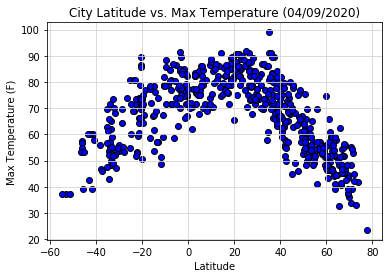

In [51]:
# Build a scatter plot for Latitude vs.Temperature in Fahrenheit
plt.scatter(humidityclean_df["Lat"], humidityclean_df["Max Temp"], marker="o",edgecolors='black', facecolors= "blue")

# Incorporate the other graph properties
plt.title("City Latitude vs. Max Temperature (04/09/2020)")
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")
plt.grid (b=True,which="major",axis="both",linestyle="-",color="lightgrey")

plt.savefig("output_data2/fig1.png")

plt.show()




#### There is a posible positive relation between both parameters, Latitude and Temperature, since both seems to move in a very simetric way. 
As you move south of the equator from latitude 0 to latitude -60 it is visible a linear temperature increase. Same seems to follow as you move north of the equator from a latitude of 0 to a latitude of 80 we see what appears to be a linear decrease in temperature.

## Latitude vs. Humidity Plot

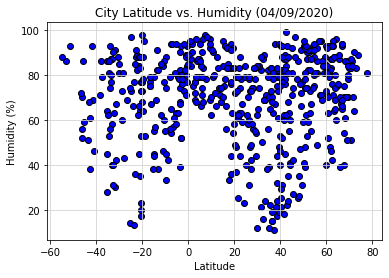

In [52]:
# Build a scatter plot for Latitude vs.Humidity in Fahrenheit
plt.scatter(humidityclean_df["Lat"], humidityclean_df["Humidity"], marker="o",edgecolors='black', facecolors= "blue")

# Incorporate the other graph properties
plt.title("City Latitude vs. Humidity (04/09/2020)")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.grid (b=True,which="major",axis="both",linestyle="-",color="lightgrey")

plt.savefig("output_data2/fig2.png")

plt.show()



#### It is a visible negative relation between both parameters, Latitude and Humidity, since data is not simetric. 
They do not seem to have a strong correlation. One can say however, that it appears more cities have a humidity above 60% than a humidity below 60%. It will be interesting to see if grouping by Northern vs. Southern Hemispheres will reveal a different trend.

## Latitude vs. Cloudiness Plot

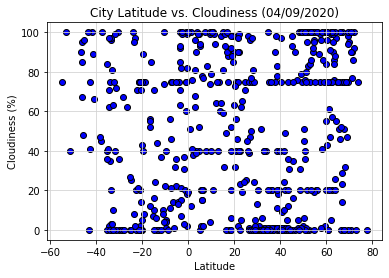

In [60]:
# Build a scatter plot for Latitude vs.Humidity in Fahrenheit
plt.scatter(humidityclean_df["Lat"], humidityclean_df["Cloudiness"], marker="o",edgecolors='black', facecolors= "blue")

# Incorporate the other graph properties
plt.title("City Latitude vs. Cloudiness (04/09/2020)")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.grid (b=True,which="major",axis="both",linestyle="-",color="lightgrey")

plt.savefig("output_data2/fig3.png")

plt.show()

#### It is definitively a negative relation between both parameters, Latitude and Cloudiness, since data is very disperse. 
Even though there seems to be a group of points across all latitudes at either 0%, 75% or 100% Cloudy. Given the "lines" we see at discreet %Cloudiness levels across all latitudes, I'd think this measure is subjective.

## Latitude vs. Wind Speed Plot

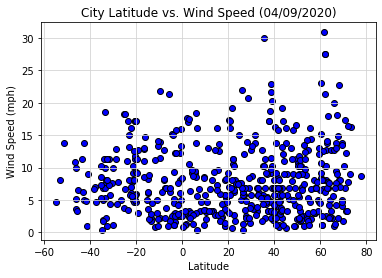

In [61]:
# Build a scatter plot for Latitude vs.Humidity in Fahrenheit
plt.scatter(humidityclean_df["Lat"], humidityclean_df["Wind Speed"], marker="o",edgecolors='black', facecolors= "blue")

# Incorporate the other graph properties
plt.title("City Latitude vs. Wind Speed (04/09/2020)")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.grid (b=True,which="major",axis="both",linestyle="-",color="lightgrey")

plt.savefig("output_data2/fig4.png")

plt.show()

#### It is a visible negative relation between both parameters, Latitude and Wind Speed, since data is not quite simetric . 
It seems to be no correlation between Wind Speed and Latitude. One can say that, regardless of latitude, wind speed grouped  between 0-15 mph range, and grouped the most on the 0-10 mph range.

## Linear Regression

In [62]:
# OPTIONAL: Create a function to create Linear Regression plots

#### Next we have to run a linear regression on each relationship. But this time separating them into Northern Hemisphere (greater than or equal to 0 degrees latitude) and Southern Hemisphere (less than 0 degrees latitude). The scatterplots must be created are as follows:

Northern Hemisphere - Temperature (F) vs. Latitude

Southern Hemisphere - Temperature (F) vs. Latitude

Northern Hemisphere - Humidity (%) vs. Latitude

Southern Hemisphere - Humidity (%) vs. Latitude

Northern Hemisphere - Cloudiness (%) vs. Latitude

Southern Hemisphere - Cloudiness (%) vs. Latitude

Northern Hemisphere - Wind Speed (mph) vs. Latitude

Southern Hemisphere - Wind Speed (mph) vs. Latitude

In [63]:
#Verify df types to see if no problem with data handling
humidityclean_df.dtypes

City           object
Lat           float64
Lng           float64
Max Temp      float64
Humidity        int64
Cloudiness      int64
Wind Speed    float64
Country        object
Date            int64
dtype: object

In [64]:
# Create Northern and Southern Hemisphere DataFrames
#Create a subset dataframes for Northern and Southern Hemispheres
northern_df = humidityclean_df.loc[humidityclean_df["Lat"] >= 0.0]
northern_df.reset_index(inplace=True)

northern_df


,index,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,0,Cabo San Lucas,22.89,-109.91,84.99,78,5,8.05,MX,1599279129
1,3,Hilo,19.73,-155.09,82.40,58,90,9.17,US,1599279496
2,4,Pevek,69.70,170.31,36.16,83,95,1.77,RU,1599278979
3,5,Tiznit Province,29.58,-9.50,75.58,54,0,1.45,MA,1599279496
4,8,Ribeira Grande,38.52,-28.70,69.91,75,11,21.68,PT,1599279497
...,...,...,...,...,...,...,...,...,...,...
369,543,Broome,42.25,-75.83,57.20,62,1,4.70,US,1599279675
370,546,Rome,43.21,-75.46,57.00,81,1,5.82,US,1599279301
371,549,Provincia di Imperia,43.97,7.78,71.60,60,0,1.12,IT,1599279677
372,551,Villavieja,39.85,-0.18,66.99,79,0,3.18,ES,1599279678


In [65]:
southern_df = humidityclean_df.loc[humidityclean_df["Lat"] < 0.0]
southern_df.reset_index(inplace=True)

southern_df

,index,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,1,Rivadavia,-33.19,-68.46,51.80,40,0,8.05,AR,1599279495
1,2,Saint-Philippe,-21.36,55.77,64.40,88,75,9.17,RE,1599279000
2,6,Mataura,-46.19,168.86,57.51,52,85,5.14,NZ,1599279497
3,10,São João da Barra,-21.64,-41.05,71.33,84,1,7.72,BR,1599279010
4,13,Nelson,-41.28,173.28,60.01,69,89,1.01,NZ,1599279499
...,...,...,...,...,...,...,...,...,...,...
159,540,Kerema,-7.96,145.78,80.37,79,56,8.30,PG,1599279674
160,544,Reyes,-14.32,-67.38,76.21,57,24,2.10,BO,1599279676
161,545,Sambava,-14.27,50.17,68.90,69,6,8.90,MG,1599279450
162,547,Barra da Estiva,-13.63,-41.33,56.95,91,44,2.77,BR,1599279677


####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The correlation factor for (Max Temp and Lat) is -0.8


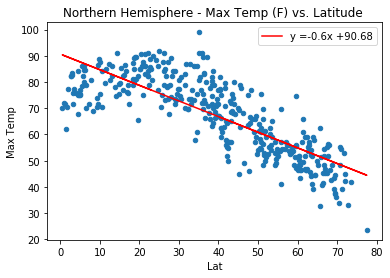

In [66]:
#Linear Regression matplotlib step by step
temp_nr= northern_df["Max Temp"]
lat_nr= northern_df["Lat"]

correlation = st.pearsonr(lat_nr, temp_nr)

print(f"The correlation factor for (Max Temp and Lat) is {round(correlation[0],2)}")

(slope, intercept, rvalue, pvalue, stderr) = st.linregress(lat_nr, temp_nr)
regress_values = lat_nr * slope + intercept
line_eq = "y =" + str(round(slope,2)) + "x +" + str(round(intercept,2))

northern_df.plot(kind="scatter", x="Lat", y="Max Temp", 
                title="Northern Hemisphere - Max Temp (F) vs. Latitude ")

plt.plot(lat_nr, regress_values, "r-", label= line_eq)
plt.legend()
plt.savefig("output_data2/nrlineregress1.png")
plt.show()

#### In the Northern Hemisphere there is a positive correlation toward higher latitude and lower temperatures, which means that there is a moderate high correlation between both parameters.


####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The correlation factor for (Max Temp and Lat) is 0.7


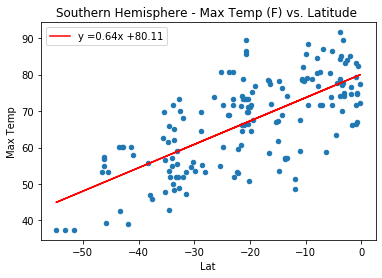

In [67]:
#Linear Regression matplotlib step by step
temp_sr= southern_df["Max Temp"]
lat_sr= southern_df["Lat"]

correlation = st.pearsonr(lat_sr, temp_sr)

print(f"The correlation factor for (Max Temp and Lat) is {round(correlation[0],2)}")

(slope, intercept, rvalue, pvalue, stderr) = st.linregress(lat_sr, temp_sr)
regress_values = lat_sr * slope + intercept
line_eq = "y =" + str(round(slope,2)) + "x +" + str(round(intercept,2))

southern_df.plot(kind="scatter", x="Lat", y="Max Temp", 
                title="Southern Hemisphere - Max Temp (F) vs. Latitude ")

plt.plot(lat_sr, regress_values, "r-", label= line_eq)
plt.legend()
plt.savefig("output_data2/srlineregress2.png")
plt.show()

#### In the southern Hemisphere there is a positive correlation toward higher latitude and higher temperatures, which means that there is a high correlation between both parameters.


####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The correlation factor for (Humidity and Lat) is 0.02


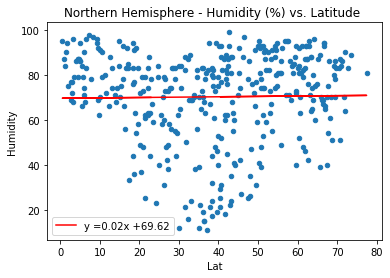

In [68]:
#Linear Regression matplotlib step by step
humidity_nr= northern_df["Humidity"]
lat_nr= northern_df["Lat"]

correlation = st.pearsonr(lat_nr, humidity_nr)

print(f"The correlation factor for (Humidity and Lat) is {round(correlation[0],2)}")

(slope, intercept, rvalue, pvalue, stderr) = st.linregress(lat_nr, humidity_nr)
regress_values = lat_nr * slope + intercept
line_eq = "y =" + str(round(slope,2)) + "x +" + str(round(intercept,2))

northern_df.plot(kind="scatter", x="Lat", y="Humidity", 
                title="Northern Hemisphere - Humidity (%) vs. Latitude ")

plt.plot(lat_nr, regress_values, "r-", label= line_eq)
plt.legend()
plt.savefig("output_data2/nrlineregress3.png")
plt.show()

#### In the northern hemisphere correlation between humidity and latitude is almost nule


####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The correlation factor for (Humidity and Lat) is 0.1


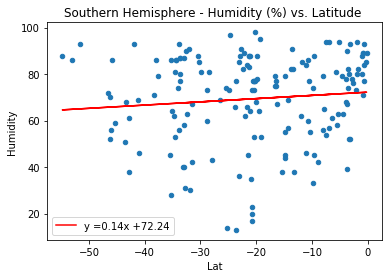

In [69]:
#Linear Regression matplotlib step by step
humidity_sr= southern_df["Humidity"]
lat_sr= southern_df["Lat"]

correlation = st.pearsonr(lat_sr, humidity_sr)

print(f"The correlation factor for (Humidity and Lat) is {round(correlation[0],2)}")

(slope, intercept, rvalue, pvalue, stderr) = st.linregress(lat_sr, humidity_sr)
regress_values = lat_sr * slope + intercept
line_eq = "y =" + str(round(slope,2)) + "x +" + str(round(intercept,2))

southern_df.plot(kind="scatter", x="Lat", y="Humidity", 
                title="Southern Hemisphere - Humidity (%) vs. Latitude ")

plt.plot(lat_sr, regress_values, "r-", label= line_eq)
plt.legend()
plt.savefig("output_data2/srlineregress4.png")
plt.show()

#### In the southern hemisphere correlation between humidity and latitude is also almost nule


####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The correlation factor for (Humidity and Lat) is 0.07


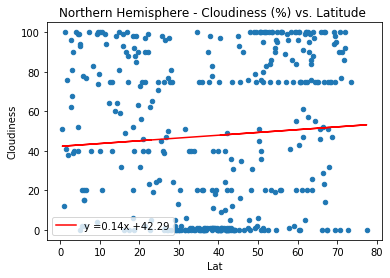

In [70]:
#Linear Regression matplotlib step by step
cloudiness_nr= northern_df["Cloudiness"]
lat_nr= northern_df["Lat"]

correlation = st.pearsonr(lat_nr, cloudiness_nr)

print(f"The correlation factor for (Cloudiness and Lat) is {round(correlation[0],2)}")

(slope, intercept, rvalue, pvalue, stderr) = st.linregress(lat_nr, cloudiness_nr)
regress_values = lat_nr * slope + intercept
line_eq = "y =" + str(round(slope,2)) + "x +" + str(round(intercept,2))

northern_df.plot(kind="scatter", x="Lat", y="Cloudiness", 
                title="Northern Hemisphere - Cloudiness (%) vs. Latitude ")

plt.plot(lat_nr, regress_values, "r-", label= line_eq)
plt.legend()
plt.savefig("output_data2/nrlineregress5.png")
plt.show()

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The correlation factor for (Cloudiness and Lat) is 0.1


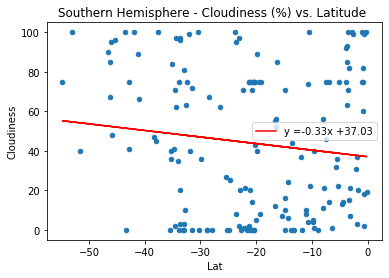

In [71]:
#Linear Regression matplotlib step by step
cloudiness_sr= southern_df["Cloudiness"]
lat_sr= southern_df["Lat"]

correlation = st.pearsonr(lat_sr, humidity_sr)

print(f"The correlation factor for (Cloudiness and Lat) is {round(correlation[0],2)}")

(slope, intercept, rvalue, pvalue, stderr) = st.linregress(lat_sr, cloudiness_sr)
regress_values = lat_sr * slope + intercept
line_eq = "y =" + str(round(slope,2)) + "x +" + str(round(intercept,2))

southern_df.plot(kind="scatter", x="Lat", y="Cloudiness", 
                title="Southern Hemisphere - Cloudiness (%) vs. Latitude ")

plt.plot(lat_sr, regress_values, "r-", label= line_eq)
plt.legend()
plt.savefig("output_data2/srlineregress6.png")
plt.show()

#### Correlation between cloudiness and latitude within northern and southern hemispheres is basically unexistant. There is no correlation at all.


####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The correlation factor for (Wind Speed and Lat) is 0.07


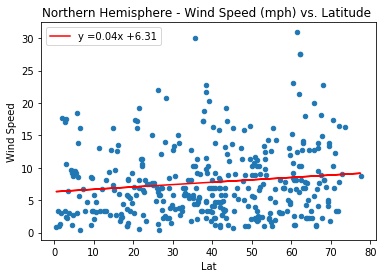

In [72]:
#Linear Regression matplotlib step by step
wspeed_nr= northern_df["Wind Speed"]
lat_nr= northern_df["Lat"]

correlation = st.pearsonr(lat_nr, cloudiness_nr)

print(f"The correlation factor for (Wind Speed and Lat) is {round(correlation[0],2)}")

(slope, intercept, rvalue, pvalue, stderr) = st.linregress(lat_nr, wspeed_nr)
regress_values = lat_nr * slope + intercept
line_eq = "y =" + str(round(slope,2)) + "x +" + str(round(intercept,2))

northern_df.plot(kind="scatter", x="Lat", y="Wind Speed", 
                title="Northern Hemisphere - Wind Speed (mph) vs. Latitude ")

plt.plot(lat_nr, regress_values, "r-", label= line_eq)
plt.legend()
plt.savefig("output_data2/nrlineregress7.png")
plt.show()

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The correlation factor for (Wind Speed and Lat) is 0.1


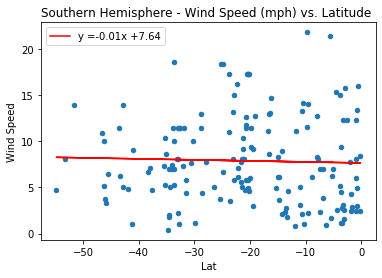

In [73]:
#Linear Regression matplotlib step by step
wspeed_sr= southern_df["Wind Speed"]
lat_sr= southern_df["Lat"]

correlation = st.pearsonr(lat_sr, humidity_sr)

print(f"The correlation factor for (Wind Speed and Lat) is {round(correlation[0],2)}")

(slope, intercept, rvalue, pvalue, stderr) = st.linregress(lat_sr, wspeed_sr)
regress_values = lat_sr * slope + intercept
line_eq = "y =" + str(round(slope,2)) + "x +" + str(round(intercept,2))

southern_df.plot(kind="scatter", x="Lat", y="Wind Speed", 
                title="Southern Hemisphere - Wind Speed (mph) vs. Latitude ")

plt.plot(lat_sr, regress_values, "r-", label= line_eq)
plt.legend()
#plt.savefig("output_data2/srlineregress8.png")
plt.show()

#### Correlation between wind speed and latitude within northern and southern hemispheres is also unexistant. There is no correlation at all.
